## Importing the Data

In [23]:
# Constants
DATASET_DIR = './data/'
GLOVE_DIR = './glove.6B/'
SAVE_DIR = './'

import os
import pandas as pd

val_x = pd.read_csv(os.path.join(DATASET_DIR, '4_feature_data/valid_set_7_8_12_15.tsv'), sep='\t', encoding='ISO-8859-1')
val_x = val_x.drop(columns=["domain1_predictionid", "domain2_predictionid"])

# for some reason normed data works "Terribly"
normed_x = pd.read_csv(os.path.join(DATASET_DIR, '4_feature_data/7_8_normalized_shifted.tsv'), sep='\t', encoding='ISO-8859-1')
normed_x = normed_x.dropna(axis=1)
normed_x = normed_x.drop(columns=['domain1_score','rater1_domain1','rater2_domain1','rater1_trait1', 'rater1_trait2', 'rater1_trait3', 
                            'rater1_trait4', 'rater2_trait1','rater2_trait2', 'rater2_trait3','rater2_trait4'])
normed_y = normed_x[['f1','f2','f3','f4']]
normed_y = normed_x[['7.1=8.1','7.2=8.2','7.3=8.4,8.5','7.4=8.6']]

new_x = pd.read_csv(os.path.join(DATASET_DIR, '4_feature_data/training_7_8_full_features_1212.tsv'), sep='\t', encoding='ISO-8859-1')
new_x = new_x.dropna(axis=1)
new_x = new_x.drop(columns=['domain1_score','rater1_domain1','rater2_domain1','rater1_trait1', 'rater1_trait2', 'rater1_trait3', 
                            'rater1_trait4', 'rater2_trait1','rater2_trait2', 'rater2_trait3','rater2_trait4'])
new_y = new_x[['7.1=8.1','7.2=8.2','7.3=8.4,8.5','7.4=8.6']]
new_y.head()

X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
for_kappa = X[['rater1_domain1', 'rater2_domain1']]


In [24]:
X = X[X.essay_set > 6]
# X = X.dropna(axis=1)
X.head()
X.columns

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'rater3_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2',
       'domain2_score', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3',
       'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1',
       'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5',
       'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3',
       'rater3_trait4', 'rater3_trait5', 'rater3_trait6'],
      dtype='object')

Minimum and Maximum Scores for each essay set.

## Preprocessing the Data

We will preprocess all essays and convert them to feature vectors so that they can be fed into the RNN.

These are all helper functions used to clean the essays.

In [25]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
#     index2word_set = set(model.wv.index2word)
    index2word_set = set(model.wv.index_to_key) # new
    
    for word in words:
        if word in index2word_set:
            num_words += 1
#           featureVec = np.add(featureVec,model[word])
            featureVec = np.add(featureVec,model.wv[word]) # new Aidan
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

Here we define a 2-Layer LSTM Model. 

Note that instead of using sigmoid activation in the output layer we will use
Relu since we are not normalising training labels.

In [26]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='relu')) # this is important

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

Using TensorFlow backend.
/home/aidan_oneill/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aidan_oneill/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aidan_oneill/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aidan_oneill/.local/lib/python3.6/site-pa

## Training Phase

Now we train the model on the dataset.

We will use 5-Fold Cross Validation and measure the Quadratic Weighted Kappa for each fold.
We will then calculate Average Kappa for all the folds.

In [27]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

# cv = KFold(len(X), n_folds=5, shuffle=True)
kf = KFold(n_splits=5,shuffle=True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in kf.split(normed_x):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = new_x.iloc[testcv], new_x.iloc[traincv], new_y.iloc[testcv], new_y.iloc[traincv]
    
    train_essays = X_train['essay']
    test_essays = X_test['essay']
    
    # making predictions on the validation dataset here:
    validation_essays = val_x['essay']
    
    sentences = []
    
    for essay in train_essays:
            # Obtaining all sentences from the training essays.
            sentences += essay_to_sentences(essay, remove_stopwords = True)
            
    # new aidan, just add some more sentences to help out the word2vec model
    for essay in validation_essays:
        sentences += essay
            
    # Initializing variables for word2vec model.
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    # new Aidan
#     model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling) 
    model = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count = min_word_count, window = context, sample = downsampling)

#     model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel_4targets.bin', binary=True)

    clean_train_essays = []
    
    # Generate training and testing data word vectors.
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    
    clean_test_essays = []
    
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
    
    # Copy the logic for training and testing to make validation data word vectors
    clean_val_essays = []
    for essay_v in validation_essays:
        clean_val_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True))
    valDataVecs = getAvgFeatureVecs(clean_val_essays, model, num_features)
    
    
    
    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    valDataVecs = np.array(valDataVecs)
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    valDataVecs = np.reshape(valDataVecs, (valDataVecs.shape[0], 1, valDataVecs.shape[1]))
    
    lstm_model = get_model()
    # originall epochs 50, batch_size 64
    lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=50)
    #lstm_model.load_weights('./model_weights/final_lstm.h5')
    y_pred = lstm_model.predict(testDataVecs)
    
    # Save any one of the 8 models.
    if count == 5:
         lstm_model.save('./model_weights/final_lstm_4targets.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    y_test = np.around(y_test)
#     print(y_pred[:,1][:25])


    # new aidan 
    y_pred_categories = []
    y_test_values_categories = []
    result = []
    for category_index in range(4):
        y_pred_categories.append(y_pred[:,category_index]) # actually unnecessary
        y_test_values_categories.append(y_test.values[:,category_index]) # unnecessary
        result.append(cohen_kappa_score(y_test.values[:,category_index],y_pred[:,category_index],weights='quadratic'))
        print("Kappa Score for category {}: {}".format(category_index, result[-1]))                                                                       
    
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    
    # old
#     result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
#     print("Kappa Score: {}".format(result))

    results.append(result)

    count += 1
        


--------Fold 1--------

Training Word2Vec Model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 814,900
Trainable params: 814,900
Non-trainable params: 0
_________________________________________________________________

Epoch 1/50
1833/1833 [==============================] - 1s 750us/step - loss: 2.5515 - mae: 1.2598
Epoch 2/50
1833/1833 [==============================] - 0s 204us/step - loss: 0.9529 - mae: 0.

1833/1833 [==============================] - 0s 207us/step - loss: 0.5998 - mae: 0.6020
Epoch 11/50
1833/1833 [==============================] - 0s 197us/step - loss: 0.5761 - mae: 0.5988
Epoch 12/50
1833/1833 [==============================] - 0s 192us/step - loss: 0.5990 - mae: 0.6069
Epoch 13/50
1833/1833 [==============================] - 0s 193us/step - loss: 0.6016 - mae: 0.6069
Epoch 14/50
1833/1833 [==============================] - 0s 194us/step - loss: 0.5732 - mae: 0.5938
Epoch 15/50
1833/1833 [==============================] - 0s 195us/step - loss: 0.5690 - mae: 0.5908
Epoch 16/50
1833/1833 [==============================] - 0s 203us/step - loss: 0.5820 - mae: 0.5991
Epoch 17/50
1833/1833 [==============================] - 0s 203us/step - loss: 0.5513 - mae: 0.5824
Epoch 18/50
1833/1833 [==============================] - 0s 208us/step - loss: 0.5555 - mae: 0.5852
Epoch 19/50
1833/1833 [==============================] - 0s 196us/step - loss: 0.5257 - mae: 0.5673
Epoch 20/50


1834/1834 [==============================] - 0s 209us/step - loss: 0.5070 - mae: 0.5528
Epoch 31/50
1834/1834 [==============================] - 0s 200us/step - loss: 0.4724 - mae: 0.5413
Epoch 32/50
1834/1834 [==============================] - 0s 199us/step - loss: 0.4932 - mae: 0.5470
Epoch 33/50
1834/1834 [==============================] - 0s 196us/step - loss: 0.4766 - mae: 0.5386
Epoch 34/50
1834/1834 [==============================] - 0s 199us/step - loss: 0.4941 - mae: 0.5508
Epoch 35/50
1834/1834 [==============================] - 0s 198us/step - loss: 0.4694 - mae: 0.5380
Epoch 36/50
1834/1834 [==============================] - 0s 207us/step - loss: 0.4925 - mae: 0.5476
Epoch 37/50
1834/1834 [==============================] - 0s 201us/step - loss: 0.4625 - mae: 0.5394
Epoch 38/50
1834/1834 [==============================] - 0s 203us/step - loss: 0.4637 - mae: 0.5397
Epoch 39/50
1834/1834 [==============================] - 0s 196us/step - loss: 0.4722 - mae: 0.5389
Epoch 40/50


1834/1834 [==============================] - 0s 207us/step - loss: 0.4443 - mae: 0.5256
Kappa Score for category 0: 0.7722948106890339
Kappa Score for category 1: 0.7317476311256931
Kappa Score for category 2: 0.7559724722964425
Kappa Score for category 3: 0.6492509534706331

--------Fold 5--------

Training Word2Vec Model...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 814,900
Trainable params: 814,900
Non-trai

In [28]:
cohen_kappa_score(for_kappa['rater1_domain1'], for_kappa['rater2_domain1'], weights='quadratic')
len(for_cappa['rater1_domain1'])

12976

The Avg. Kappa Score is 0.961

In [29]:
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))
print("Kappa Scores: Fold by Writing Evaluation metric")
print(np.around(np.array(results),decimals=4))

Average Kappa score after a 5-fold cross validation:  0.7733
Kappa Scores: Fold by Writing Evaluation metric
[[0.8233 0.7826 0.8005 0.7517]
 [0.8131 0.7801 0.8025 0.7234]
 [0.801  0.7989 0.8127 0.7036]
 [0.7723 0.7317 0.756  0.6493]
 [0.8228 0.8031 0.8109 0.7268]]


In [30]:
# print(y_pred[:25])
# print(len(y_pred[:,1]))
# print(type(y_pred))

print(y_test.values[:25])
# np.around(y_test.values[:,category_index])


[[2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]
 [2. 2. 2. 2.]
 [2. 2. 2. 3.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 1. 2. 2.]
 [2. 2. 2. 2.]
 [3. 3. 2. 2.]
 [2. 2. 2. 2.]
 [3. 3. 2. 3.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]
 [1. 2. 2. 2.]
 [1. 1. 2. 2.]
 [0. 1. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 3.]
 [2. 2. 2. 2.]
 [1. 2. 1. 1.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 3. 2. 2.]]


In [31]:
# Can I test on a sample essay?

# Yes, just put the essay in here

essay_file = open(os.path.join(DATASET_DIR, 'testEssay.txt'))
essay_file = open(os.path.join(DATASET_DIR, 'essay7_1.txt'))
essay_file = open(os.path.join(DATASET_DIR, 'testEssay8_bad.txt'))
# essay_file = open(os.path.join(DATASET_DIR, 'testEssay8_best.txt'))
essay = essay_file.read()
bad_essay = "I don't like computers because they don't work."
essay = bad_essay
essay = "Dear @ORGANIZATION1, @CAPS1 has been brought to my attention that some people feel that computers are bad for us. Some people say that they are a distraction to our physicaland mental health. Although I can see how some people would think this, I believe that computers are a good benifit to all society. I believe this because computers can help people learn, stay intach with friends or family that live faraway, and stay orginized. Sometimes people are on the computer, learning and they don't even know @CAPS1. Simply by visiting the @ORGANIZATION2 homepage, you automaticly see the news feeds of things happening around the world. Other times people go online diliberatly to learn. If someone is thinking about going to @LOCATION1 then they would probably go on the internet to learn about @CAPS1. Simply by searching equadore many choices will pop up you climate, sesonal weather, hotel options, and other farts. But thats not the only way people are learning on the internet. Now, many college students have the option of taking their lessons online. This is because some students like calm quietness or own house the distractions of sitting in class. Friends could be a big distraction in class, but how can you stay intouch with your friends if they moved away? I remember in second grade my bestfriend, @LOCATION2, move away. I was so sad. I badey ever talked to her, but then one day our parents set us up on a vidio chat! I felt like I was right their with her! This was great, and I though about how many people could use this to talk to relatives or friends. Another great way to stay intouch into friends and family is through e-mail. By writing a message and sending @CAPS1 can make staying in touch so easey, and your personal wants can chat and emails are a easey thing to send world wide. So many people love to type on a keyboard as well, but so many different papers that you type could be lost. I, for me, hate clutter, and I have so many school binders for papers to be lost in. This is why I take great advantage of typing my paper every chance I get. My computer keeps me orginiced because I could never loose my work. File save, is an idiot proof way to keep all your files in a safe place. Then all you have to do is press print to get a hard copy. I am sure that many people love using their computer for the same reason. Also, I myself am a much faster typer than I am writer so my work is a lot needey on the computer. As you can see their are plenty of reasons why using a computer is goof for our society you can learn, stay intouch with friends and family, and stay orginiced. Many people, could agree with me. Don't you?"
print("Your essay begins:", essay[0:200],"...")
print('')

clean_essay = essay_to_wordlist( essay, remove_stopwords=True)
print("After cleaning, the essay still has {} of its original {} words".format(len(clean_essay),len(essay.split(' '))))

vec = getAvgFeatureVecs([clean_essay], model, num_features)

vec = np.array(vec)

vec = np.reshape(vec, (vec.shape[0], 1, vec.shape[1]))
prediction = lstm_model.predict(vec)[0]
rounded_preds = [round(ele,9) for ele in prediction]

predictions = lstm_model.predict(valDataVecs)


print("For an essay from set 7")

print("")
print("You scored:")
print("Ideas", rounded_preds[0])
print("Organization", rounded_preds[1])
print("Style", rounded_preds[0])
print("Conventions", rounded_preds[0])

print("where each score is out of 3")
print("in total, you scored a", round(sum(prediction),1),"out of 60")

print(np.amax(predictions))

Your essay begins: Dear @ORGANIZATION1, @CAPS1 has been brought to my attention that some people feel that computers are bad for us. Some people say that they are a distraction to our physicaland mental health. Although ...

After cleaning, the essay still has 254 of its original 488 words
For an essay from set 7

You scored:
Ideas 3.3643687
Organization 3.4387226
Style 3.3643687
Conventions 3.3643687
where each score is out of 3
in total, you scored a 13.7 out of 60
4.446832


In [32]:
import pdfplumber
from os import listdir

In [44]:
mydirs = ['./data/1-TheAthenianSchool-D4zNusnYjVD2oDCbEmHsjjEqtmu', './data/2-BentleySchool-2d2qyLVjyZwiSJXcRTuVcLAF68dx', './data/3-Head-RoyceSchool-3kHQRXy8p4BhS7ztgVB45rUwTm8M', './data/4-TheCollegePreparatorySchool-4Q7jsWcLEbVsWBP4fDjFoatbQGDL']
files = []
for mydir in mydirs:
    files += [mydir+'/'+f for f in listdir(mydir)]

In [45]:
essays = []
for f in files:
    with pdfplumber.open(f) as pdf:
        second_page = pdf.pages[1]
        sp_text = second_page.extract_text()
        ind = sp_text.find("why?")
        rind = sp_text.rfind('\n')
        essays.append(sp_text[ind+5:rind])
#         print(essays[0])
#         if(essays[0][len(essays[0])-37] == '\n'):
#             print('here')
#         print(essays[0][len(essays[0])-37])
#         break
clean_essays = [essay_to_wordlist( essay, remove_stopwords=True) for essay in essays]

vec = getAvgFeatureVecs(clean_essays, model, num_features)

vec = np.array(vec)

vec = np.reshape(vec, (vec.shape[0], 1, vec.shape[1]))
prediction = lstm_model.predict(vec)[0]
rounded_preds = [round(ele,9) for ele in prediction]

predictions = lstm_model.predict(valDataVecs)
print(rounded_preds)

[1.4527171, 2.1149938, 2.3205705, 2.490652]


In [46]:
import seaborn as sns

In [58]:
predictions = lstm_model.predict(vec)
# print(predictions)
lst = []
worst_s = None
worst_i = -1
my_sums = []
best_s = None
best_i = -1
for i in range(len(predictions)):
    pred = predictions[i]
    my_s = sum(pred)
    if worst_s is None or my_s < worst_s:
        print(worst_s)
        worst_s = my_s
        worst_i = i
    if best_s is None or best_s < my_s:
        print(best_s)
        best_s = my_s
        best_i = i
    my_sums.append(my_s)
print(files[worst_i])
print(predictions[worst_i])
print(files[best_i])
print(predictions[best_i])
my_sums
# rounded_preds = [round(ele,9) for ele in predictions]

# predictions = lstm_model.predict(valDataVecs)
# print(rounded_preds)

None
None
8.378933429718018
8.378933429718018
8.647082090377808
11.747617483139038
13.779863595962524
7.679156541824341
14.317095756530762
14.68454384803772
6.504308640956879
15.390012502670288
./data/2-BentleySchool-2d2qyLVjyZwiSJXcRTuVcLAF68dx/AlexandraGanotisOwen-1-2021-12-12-1831.pdf
[0.8410429 1.5631986 1.7666379 2.0359178]
./data/4-TheCollegePreparatorySchool-4Q7jsWcLEbVsWBP4fDjFoatbQGDL/AdeleOh-1-2021-12-12-1830.pdf
[3.9297423 3.8742292 3.9253864 3.7210133]


[8.378933429718018,
 8.647082090377808,
 7.679156541824341,
 11.747617483139038,
 10.979196071624756,
 10.760998010635376,
 8.827280521392822,
 11.305140733718872,
 7.711214303970337,
 9.252556085586548,
 13.779863595962524,
 8.18477749824524,
 13.59082317352295,
 11.596821784973145,
 12.7271249294281,
 14.317095756530762,
 12.904940366744995,
 12.084286451339722,
 6.504308640956879,
 14.68454384803772,
 12.53617811203003,
 11.384626865386963,
 10.948838233947754,
 13.291808843612671,
 15.390012502670288,
 12.056050062179565,
 13.80105996131897,
 13.512714862823486,
 14.322911977767944,
 11.995628595352173,
 13.199407577514648,
 10.979004383087158,
 7.084140717983246,
 14.039692878723145,
 11.84595012664795,
 10.987643480300903,
 8.42231273651123,
 9.107707738876343,
 13.854642868041992,
 12.986931800842285,
 7.679156541824341,
 10.979196071624756,
 7.768988370895386,
 9.252556085586548,
 13.779863595962524,
 8.18477749824524,
 9.424752950668335,
 13.775296211242676,
 11.02488088607788

In [55]:
ideas = [prediction[0] for prediction in predictions]
organization = [prediction[1] for prediction in predictions]
style = [prediction[2] for prediction in predictions]
conventions = [prediction[3] for prediction in predictions]


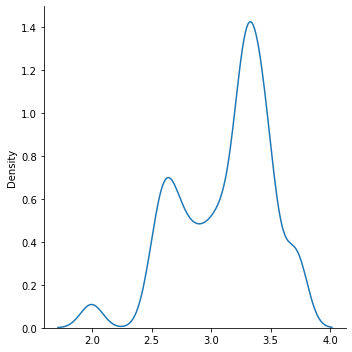

In [62]:
sns.displot(conventions, kind="kde", bw_adjust=0.5)